In [1]:
%matplotlib inline

In [2]:
# %load poi_id.py
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi". # You will need to use more features
##### 'email_address' fails featureFormat() as it is string not float, all other features imported for 
##### initial testing and investigations
features_list = ['poi', 'salary', 'bonus','deferral_payments','total_payments',  
                 'exercised_stock_options','restricted_stock','total_stock_value',
                 'expenses','deferred_income',
                 'long_term_incentive', 'other',
                 'restricted_stock_deferred', 'loan_advances', 'director_fees', 
                 'to_messages', 'shared_receipt_with_poi','from_messages',      
                 'from_this_person_to_poi', 'from_poi_to_this_person'             
                ] 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

    
for namen in data_dict:
    count = 0
    for things, values in data_dict[namen].items():
        if values == 'NaN':
            count +=1
    if count >=18:
        print namen, count
        
### Task 2: Remove outliers - remove TOTAL, Lockhardt Eugene E (all NaNs), and The Agency in the Park    
outlier = data_dict.pop('TOTAL')
outlier = data_dict.pop('LOCKHART EUGENE E')
outlier = data_dict.pop('THE TRAVEL AGENCY IN THE PARK')

### Negative outliers found in deferred_income and restricted stock deferred
### Entries for 'BELFER ROBERT' & 'BHATANGAR SANJAY' corrected as confirmed by enron61702insiderpay.pdf

data_dict['BELFER ROBERT']['deferred_income']  = -102500
data_dict['BELFER ROBERT']['deferral_payments']= 'NaN'
data_dict['BELFER ROBERT']['expenses'] = 3285
data_dict['BELFER ROBERT']['director_fees'] = 102500 
data_dict['BELFER ROBERT']['total_payments'] = 3285
data_dict['BELFER ROBERT']['exercised_stock_options']= 'NaN'
data_dict['BELFER ROBERT']['restricted_stock']= 44093
data_dict['BELFER ROBERT']['restricted_stock_deferred']= -44093
data_dict['BELFER ROBERT']['total_stock_value'] = 'NaN'

data_dict['BHATNAGAR SANJAY']['other']= 'NaN' 
data_dict['BHATNAGAR SANJAY']['expenses']= 137864
data_dict['BHATNAGAR SANJAY']['director_fees']= 'NaN'
data_dict['BHATNAGAR SANJAY']['total_payments']= 137864
data_dict['BHATNAGAR SANJAY']['exercised_stock_options']= 15456290 
data_dict['BHATNAGAR SANJAY']['restricted_stock']= 2604490
data_dict['BHATNAGAR SANJAY']['restricted_stock_deferred']= -2604490
data_dict['BHATNAGAR SANJAY']['total_stock_value']= 15456290


WHALEY DAVID A 18
WROBEL BRUCE 18
LOCKHART EUGENE E 20
THE TRAVEL AGENCY IN THE PARK 18
GRAMM WENDY L 18


/Users/wendy/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
### Task 3: Create new feature(s)

## create dataframe of dict with features as cols and names as index
## https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
from __future__ import division
import numpy as np
import pandas as pd

df_data = pd.DataFrame.from_dict({(i): data_dict[i]
                                  for i in data_dict.keys()},orient='index')

        
## List of Features that are numbers
numbers = list(df_data)  
numbers.remove('email_address') 
numbers.remove('poi')

## Ensure pd.dataframe values are 'float' for mathematical operations
for trait in [numbers]:
    df_data[trait] = df_data[trait].astype('float')

## New features:
 
df_data['take_home'] = df_data['salary'] + df_data['bonus']
df_data['percent_exercised'] = df_data['exercised_stock_options']/df_data['total_stock_value']
df_data['response_rate'] = df_data['from_messages']/df_data['to_messages']
df_data['poi_response'] = df_data['from_this_person_to_poi']/df_data['from_poi_to_this_person']
df_data['delta_response'] = df_data['from_this_person_to_poi']-df_data['from_poi_to_this_person']

### Replace Inf in poi_response with .max() + 10 to put at top of scale
m = df_data.loc[df_data['poi_response'] != np.inf, 'poi_response'].max() + 10
df_data['poi_response'].replace(np.inf,m,inplace=True)

new_features=['take_home', 'percent_exercised', 'response_rate', 'poi_response', 'delta_response']
numbers = numbers + new_features 

In [44]:
#df_data.loc[df_data['poi_response'] == np.inf]
#df_data.loc['BHATNAGAR SANJAY']
#df_data.loc['PIRO JIM']
#df_data.groupby(['poi_response']).count()
#df_data['delta_response'].describe()
print df_data.shape

(143, 26)


In [42]:
## Data Prepocessing: Imputation (replace NaNs)

df_data.dropna(0,'all')  ##unnecessary - no rows with all empty features
#df_data = df_data.replace(np.inf, np.nan) #replace inf with NaN  ##poi_response Inf dealt with as max

### Manual Imputation
imputed_mean = df_data.copy()   
imputed_median = df_data.copy()
imputed_zero = df_data.copy()
for col in numbers:
    ave =  imputed_mean[col].mean()
    imputed_mean[col] = imputed_mean[col].replace(np.nan, ave)
    imputed_median[col] = imputed_median[col].replace(np.nan, ave)
    imputed_zero[col] = imputed_zero[col].replace(np.nan, 0)

#print imputed_mean.describe()
#print imputed_mean.plot.box(rot=90)
#print imputed_zero.describe()
#print imputed_zero.plot.box(rot=90)


my_features = ['poi','salary', 'bonus','total_payments',  
               'exercised_stock_options','restricted_stock','total_stock_value',
               'expenses','deferred_income',
               'long_term_incentive', 'other',
               'to_messages', 'shared_receipt_with_poi','from_messages',      
               'from_this_person_to_poi', 'from_poi_to_this_person',
              # 'restricted_stock_deferred','loan_advances','director_fees',    ## Removed - too few values
               'deferral_payments',                                            ## Remove? - 73% NaNs
               'take_home', 'percent_exercised', 'response_rate', 'poi_response', 'delta_response' ## New features
              ]

## Store new features and corrections to my_dataset dictionary for easy export below.
my_dataset = df_data.to_dict(orient='index')               ## no pre-imputation, for imputation by pipeline
my_data_median = imputed_median.to_dict(orient='index')    ## median manual pre-imputation
my_data_mean = imputed_mean.to_dict(orient='index')        ## mean manual pre-imputation
my_data_zero = imputed_zero.to_dict(orient='index')        ## zero manual pre-imputation


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114f7a9d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118084c90>]], dtype=object)

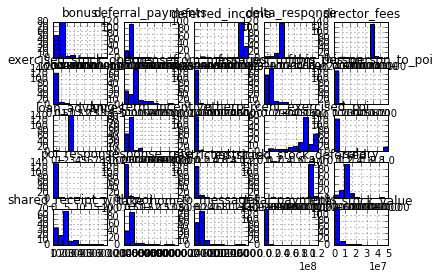

In [41]:
pd.DataFrame.hist(imputed_median)


In [45]:
### Functions for Data Extraction and train_test_split

### Extract features and labels from dataset for local testing
def feature_extraction(mydata_dict, features_lineup):
    data = featureFormat(mydata_dict, features_lineup, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    return labels,features

### Split sets for cross validation train/test data 
def split_sets(features, labels, test_amt, r_state): 
    from sklearn.cross_validation import train_test_split
    f_train, f_test, l_train, l_test = \
    train_test_split(features, labels, test_size=test_amt, random_state=r_state)
    return f_train, f_test, l_train, l_test   

In [46]:
######################
## Rank Features with various Feature Selection Methods
######################

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.preprocessing import Imputer

labels, features_raw = feature_extraction(my_dataset, my_features)

imp_mean = Imputer(missing_values=np.nan, strategy='median')
features= imp_mean.fit_transform(features_raw)

## VarianceThreshold object to rank feature variances
thresholder = VarianceThreshold()
high_variance = thresholder.fit(features)
## List Features with Ranked variances (ascending)
t_vars = thresholder.variances_
t_vars_sort = np.argsort(thresholder.variances_)
print "VarianceThreshold:"
for i in t_vars_sort:
    print i, my_features[i+1], t_vars[i]
    
scaler = StandardScaler()
features = scaler.fit_transform(features)

######################
## KBest takes Featues, target(labels), select k features
kbest = SelectKBest(f_regression).fit(features, labels)
k_scoresort = np.argsort(kbest.scores_)
k_pvals  = kbest.pvalues_
print "########  SelectKBest:"
for f in k_scoresort:
    print my_features[f+1], 'score: ', kbest.scores_[f], k_pvals[f]

#####################    
## Select Percentile, default selection function: the 10% most significant features
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features, labels)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
print "##########  SelectPercentile:"
for f in np.argsort(scores):
    print my_features[f+1], 'score: ', scores[f], k_pvals[f]


VarianceThreshold:
17 percent_exercised 0.0428556892348
18 response_rate 0.0894548270954
19 poi_response 8.41993327813
14 from_poi_to_this_person 4711.15340603
20 delta_response 5874.1310822
13 from_this_person_to_poi 6217.49630789
11 shared_receipt_with_poi 870854.226588
12 from_messages 2091963.78747
10 to_messages 4143367.05003
6 expenses 1463705686.85
0 salary 20549708177.6
7 deferred_income 334378201613.0
8 long_term_incentive 359340069307.0
15 deferral_payments 502195602396.0
1 bonus 1.21288736787e+12
9 other 1.27161273531e+12
16 take_home 1.38554742061e+12
4 restricted_stock 3.84187314364e+12
3 exercised_stock_options 2.28487079716e+13
5 total_stock_value 3.85540599423e+13
2 total_payments 7.65245705268e+13
########  SelectKBest:
percent_exercised score:  0.000401940670368 0.984033059035
poi_response score:  0.0154671467977 0.901201838337
from_messages score:  0.189798310011 0.663750746968
delta_response score:  0.20690160034 0.649906374025
response_rate score:  0.245418351257 0

In [48]:
## Review Features: correlation matrix pandas, boxplot, statistics
## https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

#imputed_median.describe()

s= imputed_median.corr()
s_order = s.unstack().sort_values(ascending=False)

for key, value in s_order.iteritems():
    if value > 0.8 and value !=1:
        print key, value


('take_home', 'bonus') 0.995309445937
('bonus', 'take_home') 0.995309445937
('exercised_stock_options', 'total_stock_value') 0.938867717086
('total_stock_value', 'exercised_stock_options') 0.938867717086
('from_messages', 'response_rate') 0.926513951173
('response_rate', 'from_messages') 0.926513951173
('to_messages', 'shared_receipt_with_poi') 0.847990014598
('shared_receipt_with_poi', 'to_messages') 0.847990014598
('total_payments', 'other') 0.826444807901
('other', 'total_payments') 0.826444807901


In [119]:
### USE top scores from Variance Threshold, SelectKBest/SelectPercentile for order, find high correlation features

### Ranked for Mean/Median Imputation
my_features = ['poi', 'exercised_stock_options', 'total_stock_value', 
               #'bonus', 
               'take_home', 
               'salary', 'deferred_income',
               'total_payments',
               'long_term_incentive', 'restricted_stock',
               'shared_receipt_with_poi',
               'from_poi_to_this_person',
               #'other',
               'from_this_person_to_poi', #'expenses',
               #'to_messages',
               #'response_rate' , #'delta_response',
               #'from_messages'#,  'poi_response', 'percent_exercised'
              ]
labels, features = feature_extraction(my_dataset, my_features)

print "Features: ", len(my_features)-1

Features:  11


In [55]:
##################
### FROM tester.py the test_classifier for use with Feature selection/algorithm optimization
##################
from sklearn.cross_validation import StratifiedShuffleSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, test_size = 0.3, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )       
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predictions."
        print (total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""

In [124]:
###########################
## Pipeline for feature reduction with PCA()/SelectKBest
## http://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html
## sphx-glr-auto-examples-compose-plot-compare-reduction-py

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler


labels, features = feature_extraction(my_dataset, my_features)
sss = StratifiedShuffleSplit(labels, 50, test_size = 0.3, random_state = 42)


## Combine PCA and Univariate Selection:
pca = PCA()
selectk = SelectKBest()
united_features = FeatureUnion([("pca", pca),("select", selectk)])


pipe = Pipeline([("impute",Imputer(strategy = 'median')),
                 ("scale", MinMaxScaler()),
                 ("features", united_features),
                 ('classify', GaussianNB())
])

K_FEATURES_OPTIONS = [1,2,3]
N_COMPS = [3,4,5]       
S_FUNC = [f_regression, f_classif, chi2]
C_OPTIONS = [25]

                  
param_grid = [{'features__pca__n_components': N_COMPS,
               'features__pca__whiten': [True, False],
               'features__select__k': K_FEATURES_OPTIONS,
               'features__select__score_func': S_FUNC,
              #'classify__C': C_OPTIONS
              },
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=sss)
grid.fit(features, labels)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
print "Pipeline Feature Reductions Union PCA()/SelectKBest "
print mean_scores
print grid.best_score_, grid.best_params_
grid.cv_results_['params'][grid.best_index_]

clf_feature_selection = grid.best_estimator_

print("Tester Scores:")
test_classifier(clf_feature_selection, my_dataset, my_features, 1000)


Pipeline Feature Reductions Union PCA()/SelectKBest 
[ 0.86325581  0.86325581  0.8627907   0.86        0.86        0.8655814
  0.85534884  0.85534884  0.86418605  0.86325581  0.86325581  0.8627907
  0.86        0.86        0.8655814   0.85534884  0.85534884  0.86418605
  0.85860465  0.85860465  0.85906977  0.85162791  0.85162791  0.85953488
  0.85069767  0.85069767  0.85906977  0.85860465  0.85860465  0.85906977
  0.85162791  0.85162791  0.85953488  0.85069767  0.85069767  0.85906977
  0.85023256  0.85023256  0.85069767  0.8455814   0.8455814   0.85116279
  0.84837209  0.84837209  0.85674419  0.85023256  0.85023256  0.85069767
  0.8455814   0.8455814   0.85116279  0.84837209  0.84837209  0.85674419]
0.865581395349 {'features__pca__n_components': 3, 'features__select__k': 2, 'features__pca__whiten': True, 'features__select__score_func': <function chi2 at 0x118017578>}
Tester Scores:
Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [125]:
############
## Pipeline for Classifier selection
############

from sklearn import tree, neighbors
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

labels, features = feature_extraction(my_dataset, my_features)
sss = StratifiedShuffleSplit(labels, 50, test_size = 0.3, random_state = 42)
## Combine PCA and Univariate Selection:

pca = PCA(n_components = 3, whiten=True)
selectk = SelectKBest(k=2, score_func = chi2)
united_features = FeatureUnion([("pca", pca),("select", selectk)])


pipe = Pipeline([('impute',Imputer(strategy = 'median')),
                 ('scale', MinMaxScaler()),
                 ('features', united_features),
                 ('classify', SVC())
])

##Classifier Parameters
C_OPTIONS = [1, 25, 50]            #SVC
SPLITS = [2, 30]                   #Decision Tree
WEIGHTS = ['distance', 'uniform']  #K Nearest Neighbors
NACHBARN = [5, 30]                 #K Nearest Neighbors
ESTIMATES = [10, 50, 75]           #Ada Boost

param_grid = [
    {
        'classify': [SVC()],
        'classify__C': C_OPTIONS 
    },
    {
        'classify': [GaussianNB()]
    },
    {
        'classify': [tree.DecisionTreeClassifier()],
        'classify__min_samples_split': SPLITS 
    },
    #{
    #    'classify': [neighbors.KNeighborsClassifier()],
    #    'classify__n_neighbors': NACHBARN,
    #    'classify__weights': WEIGHTS
    #},
    {
        'classify': [RandomForestClassifier()],
        'classify__n_estimators': ESTIMATES
    },
    {
        'classify': [AdaBoostClassifier()],
        'classify__n_estimators': ESTIMATES
    }
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv= sss)
grid.fit(features, labels)

mean_scores = np.array(grid.cv_results_['mean_test_score'])

print "Pipeline Scores of Various classifiers"
print mean_scores
print grid.best_score_
print grid.best_params_
#print grid.cv_results_['params'][grid.best_index_]

clf_classifier = grid.best_estimator_
print ("clf_CLASSIFIER", clf_classifier)

print
print("Tester Scores:")
test_classifier(clf_classifier, my_dataset, my_features, 1000)

Pipeline Scores of Various classifiers
[ 0.87581395  0.85906977  0.86        0.8655814   0.80837209  0.85860465
  0.86232558  0.86186047  0.85813953  0.8344186   0.83209302  0.83162791]
0.875813953488
{'classify__C': 1, 'classify': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)}
('clf_CLASSIFIER', Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
 ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))

Tester Scores:
Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', 

In [132]:
#########################################################
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
##http://scikit-learn.org/0.16/auto_examples/model_selection/grid_search_digits.html#example-model-selection-grid-search-digits-py
## 

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import recall_score, accuracy_score, precision_score

## Load/Prepare dataset
labels, features = feature_extraction(my_dataset, my_features)
sss = StratifiedShuffleSplit(labels, 75, test_size = 0.3, random_state = 42)

pca = PCA(n_components = 4, whiten=True)
selectk = SelectKBest(k = 2, score_func = chi2)
united_features = FeatureUnion([("pca", pca),("select", selectk)])


pipe3 = Pipeline([("impute",Imputer(strategy = 'median')),
                  ("scale", MinMaxScaler()),
                  ("features", united_features),
                  ('classify', GaussianNB())
                  ])

## Set tuning parameters for cross-validation
tune_GNBparameters = [{'classify__priors': [None]}]

tune_KNNparameters = [{'classify__n_neighbors': [25, 50, 75],
                       'classify__weights':['distance', 'uniform'],
                       'classify__algorithm': ['auto'],
                       'classify__leaf_size':[10,25,50],
                       'classify__p':[1,2]
                      }]

cees = [1,20,50] # C values
tune_SVCparameters = [{'classify__kernel': ['rbf'],
                       'classify__C': cees},
                       #'classify__gamma': [1e-5, 1e-6, 'auto']},
                      {'classify__kernel': ['linear'],
                       'classify__C': cees},
                      {'classify__kernel': ['poly'],   
                       'classify__C': cees, 
                       'classify__degree':[3, 4, 5]}
                       #'classify__gamma': [1e-5, 1e-6, 'auto']}
                     ]

tune_RFparameters = [{'classify__n_estimators': [5,10,15],
                      'classify__criterion': ['gini','entropy'],
                      'classify__min_samples_split': [2,3,5],
#                     'clasify__min_samples_leaf': [1,2,3],
                      'classify__max_features': ['auto', 1, 0.5]
                     }]

tune_ADAparameters = [{#'reduce_dim__k': kay,
                       'classify__n_estimators': [2,5,50,100],
                       'classify__algorithm': ['SAMME','SAMME.R'],
                       'classify__learning_rate': [1, 0.5, 0.25]}
                     ]

print("Parameter Tuning\n")

gs = GridSearchCV(pipe3, tune_GNBparameters, cv=sss)
gs.fit(features, labels)
clf = gs.best_estimator_

print("Best parameters:")
print(gs.best_score_, gs.best_params_)

print("Tester Scores:")
test_classifier(clf, my_dataset, my_features, 1000)


Parameter Tuning

Best parameters:
(0.85674418604651159, {'classify__priors': None})
Tester Scores:
Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('select', SelectKBest(k=2, score_func=<function chi2 at 0x118017578>))],
       transformer_weights=None)), ('classify', GaussianNB(priors=None))])
	Accuracy: 0.85753	Precision: 0.39004	Recall: 0.39940	F1: 0.39466	F2: 0.39749
	Total predictions: 43000	True positives: 1997	False positives: 3123	False negatives: 3003	True negatives: 34877



In [133]:
print("Prediction with SKfold shuffle cross validations.")
skfold = KFold(n_splits=5, shuffle=True)
for train_indices, test_indices in skfold.split(labels):
    features_train = [features[i] for i in train_indices]
    features_test = [features[i] for i in test_indices]
    labels_train = [labels[i] for i in train_indices]
    labels_test = [labels[i] for i in test_indices]

    clf_prediction = clf.predict(features_test)
    print "accuracy score: ", \
        accuracy_score(labels_test, clf_prediction)
    print "precision_score: ", \
        precision_score(labels_test, clf_prediction)
    print "recall_score", \
        recall_score(labels_test, clf_prediction)

print("Prediction with Single Split 50/50 validation")
features_train, features_test, labels_train, labels_test = split_sets(features, labels, 0.3, 9)
y_true, y_pred = labels_train, clf.predict(features_train)
print(classification_report(y_true, y_pred))
print()

### Precision Recall and F1 Metrics
def prec_recall(model, pred, labels_test):
    from sklearn.metrics import precision_score, recall_score, f1_score
    y_true = labels_test
    y_pred = pred
    print model 
    print "Precision:", precision_score(y_true, y_pred)  
    print "Recall:", recall_score(y_true, y_pred)  
    print "F1 Score:", f1_score(y_true, y_pred)
    
    
prec_recall(clf, y_pred, y_true)

Prediction with SKfold shuffle cross validations.
accuracy score:  0.793103448276
precision_score:  0.25
recall_score 0.25
accuracy score:  0.862068965517
precision_score:  0.333333333333
recall_score 0.333333333333
accuracy score:  0.862068965517
precision_score:  0.5
recall_score 0.5
accuracy score:  0.928571428571
precision_score:  0.0
recall_score 0.0
accuracy score:  0.857142857143
precision_score:  0.75
recall_score 0.5
Prediction with Single Split 50/50 validation
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94        88
        1.0       0.57      0.33      0.42        12

avg / total       0.87      0.89      0.88       100

()
Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None

In [136]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
features_list = my_features
test_classifier(clf, my_dataset, features_list)
dump_classifier_and_data(clf, my_dataset, features_list)